## Random Forrest but with relative Data (Similar to Chen Paper)

In [93]:
import pandas as pd
import numpy as np
df = pd.read_csv('cleaned_data.csv')
## Exclude all Rows where condition isnt New and which where a reactive Crawl
df = df[df['trigByReactive'] != True]
df = df[df['condition'].isin(['Neu', 'New'])]

def calculate_price_diff_and_ratio(group):
    min_price = group['price'].min()
    group['price_diff'] = group['price'] - min_price
    group['price_ratio'] = group['price'] / min_price
    return group

grouped_df = df.groupby(['asin', 'time'])
df = grouped_df.apply(calculate_price_diff_and_ratio)

# Create a new column 'is_amazon' and set its value to True if the sellerName is 'Amazon', else set it to False
df['is_amazon'] = df['sellerName'] == 'amazon'

# Count the number of rows where 'is_amazon' is True
amazon_count = df['is_amazon'].sum()

print(f"Number of rows sold by Amazon: {amazon_count}")


C:\Users\Robert Betschinger\AppData\Local\Temp\ipykernel_1952\2869518112.py:15: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df = grouped_df.apply(calculate_price_diff_and_ratio)


Number of rows sold by Amazon: 63066


In [94]:
## Encode Features with Label Encoding
##Lieferpreis
nan_rows = df[df['lieferpreis'].isna()]
amazon_count = nan_rows['sellerName'].str.contains('amazon', case=False).sum()
amazon_count
df['lieferpreis'] = df['lieferpreis'].fillna(0)
nan_rows = df[df['lieferpreis'].isna()]
print(f"Length of NAN Values for Lieferpreis: {len(nan_rows)}")
## Sellerbewertung
nan_rows = df[df['sellerbewertung'].isna()]
print(len(nan_rows))
amazon_count = nan_rows['sellerName'].str.contains('amazon', case=False).sum()
amazon_count

# Calculate the mean value of the "sellerbewertung" column
mean_sellerbewertung = df['sellerbewertung'].mean()
print(mean_sellerbewertung)

# Replace all NaN values in the "sellerbewertung" column with the mean value
df['sellerbewertung'] = df['sellerbewertung'].fillna(mean_sellerbewertung)
df['sellerbewertung'] = df['sellerbewertung'].round().astype(int)
df.info()

Length of NAN Values for Lieferpreis: 0
75258
21277.529429281847
<class 'pandas.core.frame.DataFrame'>
Int64Index: 807616 entries, 0 to 1009328
Data columns (total 25 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   asin                  807616 non-null  object 
 1   time                  807616 non-null  object 
 2   id                    807616 non-null  float64
 3   price                 807616 non-null  float64
 4   currency              807616 non-null  object 
 5   crawlTime             807616 non-null  object 
 6   condition             807616 non-null  object 
 7   sellerName            807616 non-null  object 
 8   sellerId              807616 non-null  object 
 9   sellerbewertung       807616 non-null  int32  
 10  seller_sterne         807616 non-null  float64
 11  lieferdatum           776241 non-null  object 
 12  lieferpreis           807616 non-null  float64
 13  lieferung_durch       807616 non-null 

In [95]:
##Datediff
fba_rows = df[df['Fulfillment_type'] == 'FBA']
if fba_rows.empty:
    print('There are no rows where "Fulfillment_type" is "fba".')
else:
    # Calculate the mean value of the "date_diff" column where "fulfillment_type" is "fba"
    mean_date_diff_fba = fba_rows['date_diff'].mean()
    #print(f'The mean value of "date_diff" where "Fulfillment_type  " is "fba" is: {mean_date_diff_fba}')

# Round the mean value to the nearest integer
rounded_mean_date_diff_fba = round(mean_date_diff_fba)
# Replace all NaN values in the "date_diff" column with the rounded mean value
df['date_diff'] = df['date_diff'].fillna(rounded_mean_date_diff_fba).astype(int)

In [96]:
from sklearn.preprocessing import LabelEncoder
categorical_features = ['asin', 'sellerId', 'Fulfillment_type']

# Create a LabelEncoder object and fit it to each categorical feature
for feature in categorical_features:
    le = LabelEncoder()
    df[feature] = le.fit_transform(df[feature])

In [97]:
# Convert the datetime column to a numeric value
df["time"] = pd.to_datetime(df["time"], format="%Y-%m-%d %H:%M:%S")
df["time"] = df["time"].apply(lambda x: x.timestamp())
df.tail()

,asin,time,id,price,currency,crawlTime,condition,sellerName,sellerId,sellerbewertung,...,buyBoxWinner,numberOfSellers,trigByReactive,time_gap,copyed_cause_missing,Fulfillment_type,date_diff,price_diff,price_ratio,is_amazon
1009324,973,1.679249e+09,39396.0,44.95,€,2023-03-19 17:58:12.228703,New,BERSERK MEDIA,806,461,...,False,6.0,False,-1.0,True,1,32,8.06,1.218487,False
1009325,973,1.679249e+09,39397.0,46.99,€,2023-03-19 17:58:12.229013,New,Brickcomplete - Rasche Lieferung!,101,506,...,False,6.0,False,-1.0,True,1,4,10.10,1.273787,False
1009326,973,1.679249e+09,39398.0,43.36,€,2023-03-19 17:58:12.229350,New,Taschengelddieb,699,284,...,False,6.0,False,-1.0,True,1,4,6.47,1.175386,False
1009327,973,1.679249e+09,39399.0,36.89,€,2023-03-19 17:58:12.229680,New,Renax Toys - Schnelle Lieferung,1928,234,...,False,6.0,False,-1.0,True,1,4,0.00,1.000000,False
1009328,973,1.679249e+09,39400.0,42.99,€,2023-03-19 17:58:12.229983,New,ms-plueth,1169,305,...,False,6.0,False,-1.0,True,1,4,6.10,1.165356,False


# Actual Random Forrest Classifier

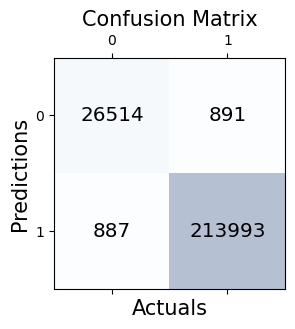

AUC: 0.9817412477330703


In [98]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import balanced_accuracy_score
import matplotlib.pyplot as plt

#Maybe its better to ignore the Column Sellerbewertung
#Testing without SellerID

#X = df[['asin','time', 'price','sellerbewertung','seller_sterne','lieferpreis','Fulfillment_type','date_diff','numberOfSellers']]
X = df[['price_diff','price_ratio','seller_sterne','sellerbewertung','Fulfillment_type','lieferpreis','date_diff','is_amazon','numberOfSellers']]
#X = df[['price_diff','price_ratio','seller_sterne','sellerbewertung','Fulfillment_type','is_amazon']]
y = df['buyBoxWinner']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)

# Create and train the Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rfc.predict(X_test)


# Calculate the confusion matrix
# The Printing of the confusion matrix, is partially buggy. Follow this Tutorial to retrive the right matrix:
##This Code is based on the Example from: https://vitalflux.com/python-draw-confusion-matrix-matplotlib/
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

# Swap True Positives and True Negatives
conf_matrix[0,0], conf_matrix[1,1] = conf_matrix[1,1], conf_matrix[0,0]

# Print the confusion matrix using Matplotlib
fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='x-large')

plt.xlabel('Actuals', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.title('Confusion Matrix', fontsize=15)
plt.show()


#Area under The Curve ausrechnen lassen
# Calculate the AUC
#The AUC (area under the ROC curve) is a measure of the performance of a binary classification model. 
#It represents the degree to which the model is able to distinguish between positive and negative examples. 
#The AUC ranges from 0 to 1, with higher values indicating better performance.
auc = roc_auc_score(y_test, y_pred)
print("AUC:", auc)

#Balanced ACC
#bal_acc = balanced_accuracy_score(y_test, y_pred)
#print("Balanced accuracy:", bal_acc)

In [99]:
num_true = (df['buyBoxWinner'] == True).sum()
num_true
print(f"The Number of Rows winning the BuyBox in the total Dataframe is {num_true}")
print(f"The Number of Rows winning the BuyBox in the Test-Set is {conf_matrix[0,0] + conf_matrix[1,0]}")

The Number of Rows winning the BuyBox in the total Dataframe is 91337
The Number of Rows winning the BuyBox in the Test-Set is 27401


In [100]:
value_counts = y_test.value_counts()
# print the result
print(value_counts)
# Count the number of rows in the train and test sets
num_rows_train = X_train.shape[0]
num_rows_test = X_test.shape[0]
# Print the results
print(f'The number of rows in the train set is: {num_rows_train}')
print(f'The number of rows in the test set is: {num_rows_test}')

False    214884
True      27401
Name: buyBoxWinner, dtype: int64
The number of rows in the train set is: 565331
The number of rows in the test set is: 242285


In [101]:
##Qualitätsmaße
# Calculate the accuracy, aber ansich nicht so gutes Maß, da imbalanced Verteilung von BuyBox
#Gewichtete Accuracy berechnen
acc = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(acc * 100))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 99.27%
Classification Report:
               precision    recall  f1-score   support

       False       1.00      1.00      1.00    214884
        True       0.97      0.97      0.97     27401

    accuracy                           0.99    242285
   macro avg       0.98      0.98      0.98    242285
weighted avg       0.99      0.99      0.99    242285



In [102]:
## Print out Feature Importances
feature_importances = rfc.feature_importances_
feature_names = X.columns
# Create a DataFrame of the feature importances and their names
feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by feature importances in descending order
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Print the DataFrame of feature importances and their names
print(feature_importances_df)

            Feature  Importance
7         is_amazon    0.212245
2     seller_sterne    0.156255
1       price_ratio    0.142265
0        price_diff    0.114495
4  Fulfillment_type    0.098187
3   sellerbewertung    0.096832
8   numberOfSellers    0.080292
5       lieferpreis    0.055252
6         date_diff    0.044176


## Test the Dataset on Unseen Data

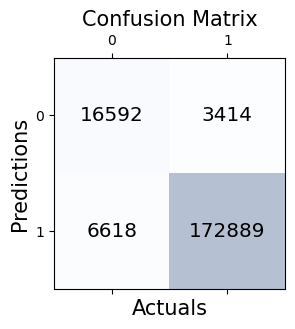

AUC: 0.8477499464606806


In [103]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import balanced_accuracy_score
import matplotlib.pyplot as plt


# Get unique 'asin' values and split them into train and test sets
unique_asins = df['asin'].unique()
train_asins, test_asins = train_test_split(unique_asins, test_size=0.25, random_state=42)

# Split the DataFrame into seen (training) and unseen (testing) data based on the train and test 'asin' sets
seen_data = df[df['asin'].isin(train_asins)]
unseen_data = df[df['asin'].isin(test_asins)]

# Prepare the seen and unseen data for the model
X_train_seen = seen_data[['is_amazon','price_diff','price_ratio','seller_sterne','sellerbewertung','Fulfillment_type','lieferpreis','date_diff','numberOfSellers']]
y_train_seen = seen_data['buyBoxWinner']

X_test_unseen = unseen_data[['is_amazon','price_diff','price_ratio','seller_sterne','sellerbewertung','Fulfillment_type','lieferpreis','date_diff','numberOfSellers']]
y_test_unseen = unseen_data['buyBoxWinner']

# Your original code to train the model and evaluate it (unchanged)
# Create and train the Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train_seen, y_train_seen)

# Make predictions on the test set
y_pred = rfc.predict(X_test_unseen)


# Calculate the confusion matrix
# The Printing of the confusion matrix, is partially buggy. Follow this Tutorial to retrive the right matrix:
##This Code is based on the Example from: https://vitalflux.com/python-draw-confusion-matrix-matplotlib/
conf_matrix = confusion_matrix(y_true=y_test_unseen, y_pred=y_pred)

# Swap True Positives and True Negatives
conf_matrix[0,0], conf_matrix[1,1] = conf_matrix[1,1], conf_matrix[0,0]

# Print the confusion matrix using Matplotlib
fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='x-large')

plt.xlabel('Actuals', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.title('Confusion Matrix', fontsize=15)
plt.show()


#Area under The Curve ausrechnen lassen
# Calculate the AUC
#The AUC (area under the ROC curve) is a measure of the performance of a binary classification model. 
#It represents the degree to which the model is able to distinguish between positive and negative examples. 
#The AUC ranges from 0 to 1, with higher values indicating better performance.
auc = roc_auc_score(y_test_unseen, y_pred)
print("AUC:", auc)

#Balanced ACC
#bal_acc = balanced_accuracy_score(y_test, y_pred)
#print("Balanced accuracy:", bal_acc)

In [104]:
num_true = (df['buyBoxWinner'] == True).sum()
num_true
print(f"The Number of Rows winning the BuyBox in the total Dataframe is {num_true}")
print(f"The Number of Rows winning the BuyBox in the Test-Set is {conf_matrix[0,0] + conf_matrix[1,0]}")

The Number of Rows winning the BuyBox in the total Dataframe is 91337
The Number of Rows winning the BuyBox in the Test-Set is 23210


In [105]:
value_counts = y_test_unseen.value_counts()
# print the result
print(value_counts)
# Count the number of rows in the train and test sets
num_rows_train = X_train_seen.shape[0]
num_rows_test = X_test_unseen.shape[0]
# Print the results
print(f'The number of rows in the train set is: {num_rows_train}')
print(f'The number of rows in the test set is: {num_rows_test}')

False    176303
True      23210
Name: buyBoxWinner, dtype: int64
The number of rows in the train set is: 608103
The number of rows in the test set is: 199513


In [107]:
##Qualitätsmaße
# Calculate the accuracy, aber ansich nicht so gutes Maß, da imbalanced Verteilung von BuyBox
#Gewichtete Accuracy berechnen
acc = accuracy_score(y_test_unseen, y_pred)
print("Accuracy: {:.2f}%".format(acc * 100))
print("Classification Report:\n", classification_report(y_test_unseen, y_pred))


Accuracy: 94.97%
Classification Report:
               precision    recall  f1-score   support

       False       0.96      0.98      0.97    176303
        True       0.83      0.71      0.77     23210

    accuracy                           0.95    199513
   macro avg       0.90      0.85      0.87    199513
weighted avg       0.95      0.95      0.95    199513



In [108]:
## Print out Feature Importances
feature_importances = rfc.feature_importances_
feature_names = X_train_seen.columns
print(feature_names)
# Create a DataFrame of the feature importances and their names
feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by feature importances in descending order
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Print the DataFrame of feature importances and their names
print(feature_importances_df)

Index(['is_amazon', 'price_diff', 'price_ratio', 'seller_sterne',
       'sellerbewertung', 'Fulfillment_type', 'lieferpreis', 'date_diff',
       'numberOfSellers'],
      dtype='object')
            Feature  Importance
0         is_amazon    0.207672
2       price_ratio    0.176019
3     seller_sterne    0.135594
1        price_diff    0.117179
4   sellerbewertung    0.100871
8   numberOfSellers    0.084010
5  Fulfillment_type    0.075508
6       lieferpreis    0.060771
7         date_diff    0.042376
